<ipython-input-5-c0f57880e2e7>:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ds'] = pd.to_datetime(df['ds'])
/usr/local/lib/python3.10/dist-packages/holidays/countries/india.py:103: Warning: Diwali and Holi holidays available from 2001 to 2030 only
  warnings.warn(warning_msg, Warning)
DEBUG:cmdstanpy:input tempfile: /tmp/tmptn3gvxus/2yab5c7_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptn3gvxus/tzqkue35.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74304', 'data', 'file=/tmp/tmptn3gvxus/2yab5c7_.json', 'init=/tmp/tmptn3gvxus/tzqkue35.json', 'output', 'file=/tmp/tmptn3gvxus/prophet_modelya2l3be0/prophet_model-20240923162542.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:

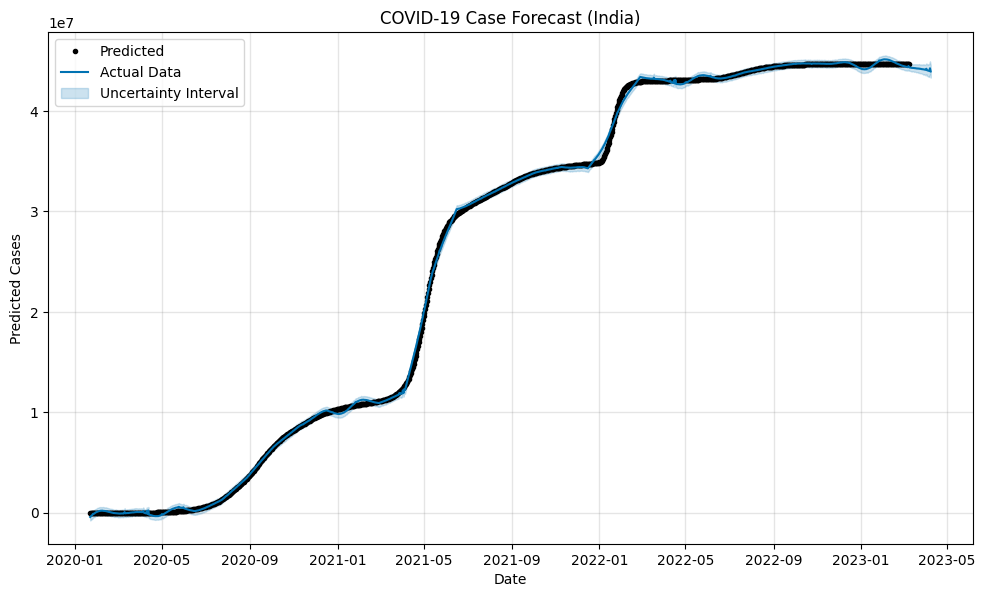

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` o

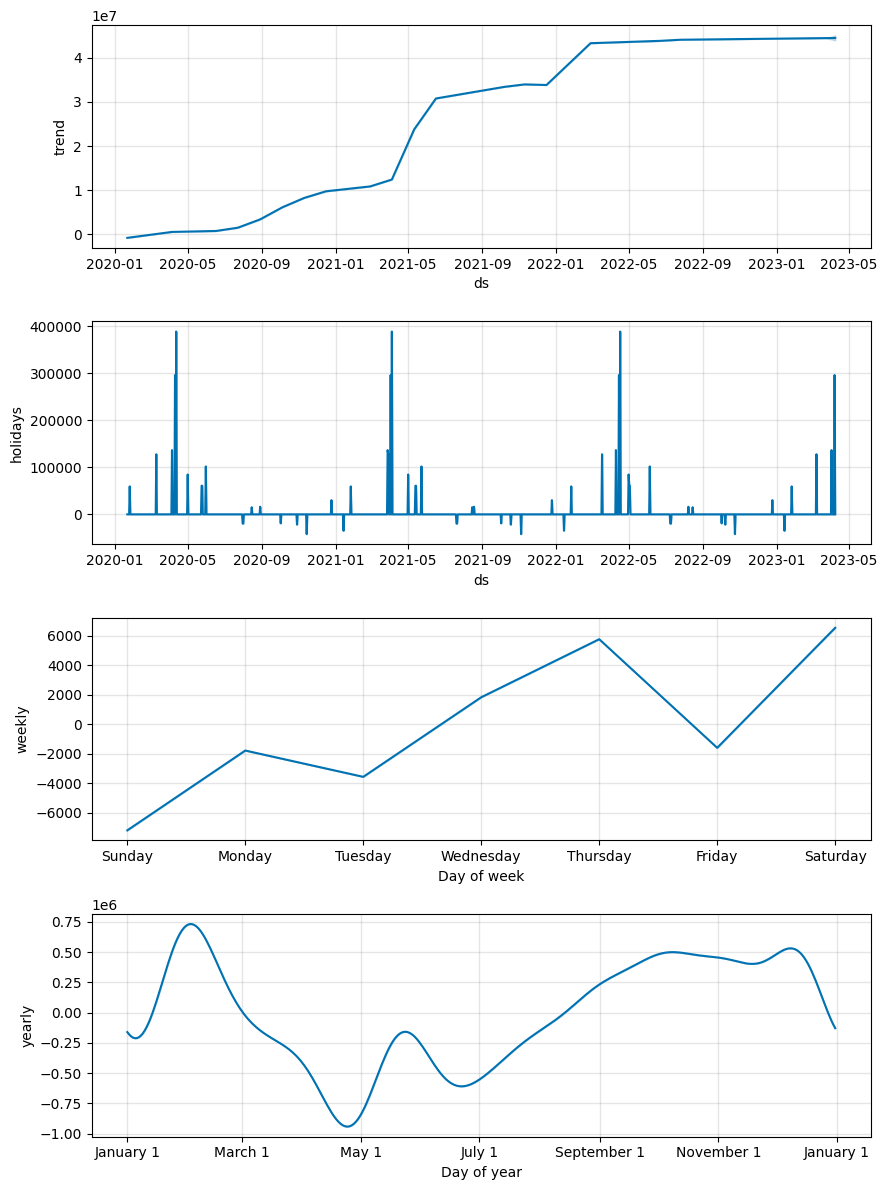

DEBUG:cmdstanpy:input tempfile: /tmp/tmptn3gvxus/179_unot.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmptn3gvxus/0mp4k07e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9644', 'data', 'file=/tmp/tmptn3gvxus/179_unot.json', 'init=/tmp/tmptn3gvxus/0mp4k07e.json', 'output', 'file=/tmp/tmptn3gvxus/prophet_model3fh4_jfy/prophet_model-20240923162546.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:25:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:25:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Mean Absolute Error (MAE): 25357074.87879853
Root Mean Squared Error (RMSE): 30427961.226697545


In [5]:
# Import necessary libraries
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Step 1: Data Preparation
# Load COVID-19 case data (JHU dataset)
# Download 'time_series_covid19_confirmed_global.csv' from JHU repository:
# https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series
df = pd.read_csv('time_series_covid19_confirmed_global.csv')

# Aggregate data for a single country (for example, 'India')
df = df[df['Country/Region'] == 'India'].drop(['Province/State', 'Lat', 'Long'], axis=1).T
df.columns = ['Cases']  # Rename the column
df = df[1:]  # Remove the first row (since it's the country name)

# Reset the index and format the data for Prophet (date as 'ds', cases as 'y')
df.reset_index(inplace=True)
df.columns = ['ds', 'y']  # Prophet requires 'ds' (date) and 'y' (target variable)

# Convert 'ds' to datetime
df['ds'] = pd.to_datetime(df['ds'])

# Step 2: FB Prophet Model Setup
# Initialize Prophet model with yearly and weekly seasonality
model = Prophet(
    yearly_seasonality=True,  # Detect yearly seasonality
    weekly_seasonality=True,  # Detect weekly seasonality
    daily_seasonality=False   # Daily seasonality is unnecessary
)

# Optional: Add holidays or known changepoints (e.g., lockdown dates)
lockdowns = pd.DataFrame({
    'holiday': 'lockdown',
    'ds': pd.to_datetime(['2020-03-15', '2020-12-15', '2021-04-01']),  # Example lockdown dates
    'lower_window': 0,
    'upper_window': 1,
})
model = model.add_country_holidays(country_name='IN')  # Add public holidays for India


# Step 3: Fit the Prophet model to historical case data
model.fit(df)

# Step 4: Make Future Predictions
# Create a dataframe for future dates
future = model.make_future_dataframe(periods=30)  # Predict the next 30 days

# Make predictions
forecast = model.predict(future)

# Step 5: Plot the forecast with a custom legend
fig = model.plot(forecast)
plt.title('COVID-19 Case Forecast (India)')
plt.xlabel('Date')
plt.ylabel('Predicted Cases')

# Add a custom legend
plt.legend(['Predicted', 'Actual Data', 'Uncertainty Interval'], loc='upper left')

plt.show()

# Step 6: Plot forecast components (Trend, Weekly Seasonality, Yearly Seasonality, Holidays)
model.plot_components(forecast)
plt.show()

# Step 7: Model Evaluation (Backtesting)
# Split the data into train and test sets (train before June 2021, test after)
train_df = df[df['ds'] < '2021-06-01']  # Train set
test_df = df[df['ds'] >= '2021-06-01']  # Test set

# Create a new Prophet model instance
model_test = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

# Fit the new model on the training data
model_test.fit(train_df)

# Predict for the test period
future_test = model_test.make_future_dataframe(periods=len(test_df))
forecast_test = model_test.predict(future_test)

# Extract actual and predicted values
actual = test_df['y'].values
predicted = forecast_test['yhat'][-len(test_df):].values

# Calculate evaluation metrics (MAE and RMSE)
mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

